# Setup (Only run if RocketCEA hasn't been built)

In [ ]:
!pip install RocketCEA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for RocketCEA: filename=rocketcea-1.1.34-cp310-cp310-linux_x86_64.whl size=5294377 sha256=aac51fb1faf2a1611279be1411e21fd5b3bd975238b30ee0ca5a75bc13f8805f
  Stored in directory: /root/.cache/pip/wheels/0a/c6/78/09f751e0e6185bac68940ca41d7ce5038ccd506209a8339781
Successfully built RocketCEA


In [ ]:
!pip install pint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 3.9 MB/s eta 0:00:00


To verify that this works, the following code will be ran.

In [ ]:
from rocketcea.cea_obj import CEA_Obj
C = CEA_Obj( oxName='LOX', fuelName='LH2')
for mr in range(2,9):
    print(mr, C.get_Isp(Pc=100.0, MR=mr, eps=40.0) )

2 424.3597085736007
3 445.44434236555196
4 453.1327195192172
5 453.240429182712
6 448.1902329983734
7 438.7434004290928
8 424.6998266323161


In [ ]:
!pip install pyfluids

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 18.4 MB/s eta 0:00:00


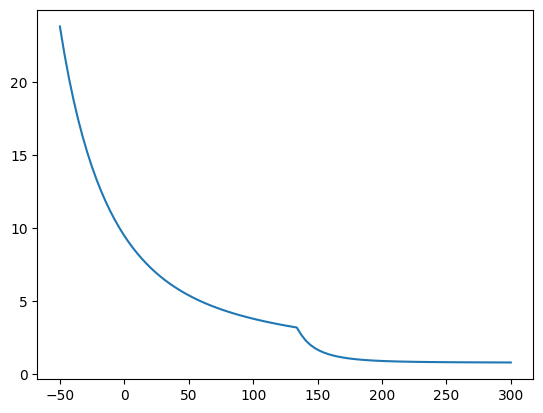

In [ ]:
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from matplotlib import pyplot as plt

templist = np.linspace(-50, 300, 100)
dens = np.zeros(100)
for i, temp in enumerate(templist):
  methanol = Fluid(FluidsList.Methanol).with_state(Input.pressure(10e5), Input.temperature(temp))
  dens[i] = methanol.prandtl
plt.plot(templist, dens)
plt.show()

In [ ]:
test_fluid = Fluid(FluidsList.Methanol).with_state(Input.pressure(40e5), Input.temperature(298.15 - 273.15))
print(f'Temperature:,{test_fluid.temperature}')
print(f'Pressure: {test_fluid.pressure}')
print()
print(f'Specific Heat: {test_fluid.specific_heat}')
print(f'Density: {test_fluid.density}')
print(f'Viscosity: {test_fluid.dynamic_viscosity}')
print(f'Conductivity: {test_fluid.conductivity}')

Temperature:,25.0
Pressure: 4000000.0

Specific Heat: 2526.3100048296174
Density: 790.3869027748791
Viscosity: 0.0005577267102988393
Conductivity: 0.20218200130080832


# Classes to generate rocket engine and contour

Firstly, a CEA wrapper

In [ ]:
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import rocketcea.cea_obj
class RocketEngine:
  def __init__(self, oxName, fuelName, thrust, Pc, Pe, MR):
    self.oxName = oxName
    self.fuelName = fuelName
    self.Pc = Pc
    self.Pe = Pe
    self.MR = MR

    self.cea = CEA_Obj(oxName = oxName,
                       fuelName = fuelName,
                       isp_units='sec',
                       cstar_units = 'm/s',
                       pressure_units='Bar',
                       temperature_units='K',
                       sonic_velocity_units='m/s',
                       enthalpy_units='J/g',
                       density_units='kg/m^3',
                       specific_heat_units='J/kg-K',
                       viscosity_units='lbf-sec/sqin',      # wtf
                       thermal_cond_units='mcal/cm-K-s',  # wtf
                       fac_CR=None,
                       make_debug_prints=False)

    self.eps = self.cea.get_eps_at_PcOvPe(Pc=Pc, MR=MR, PcOvPe = Pc/Pe)
    self.Tc, self.Tt, self.Te = self.cea.get_Temperatures(Pc=Pc, MR=MR, eps=self.eps)
    self.Pt = self.Pc / self.cea.get_Throat_PcOvPe(Pc=Pc, MR=MR)
    self.ve = self.cea.get_SonicVelocities(Pc=Pc,MR=MR,eps=self.eps)[2] * self.cea.get_MachNumber(Pc=Pc, MR=MR, eps=self.eps)
    self.mdot = thrust / self.ve

    self.mwt, self.gt = self.cea.get_Throat_MolWt_gamma(Pc=Pc, MR=MR, eps=self.eps)
    self.mwe, self.ge = self.cea.get_exit_MolWt_gamma(Pc=Pc, MR=MR, eps=self.eps)
    self.Rt = 8314.46 / self.mwt
    self.Re = 8314.46 / self.mwe

    self.Cp_c, self.Cp_t, self.Cp_e = self.cea.get_HeatCapacities(Pc=Pc, MR=MR, eps=self.eps)
    self.rho_c = self.cea.get_Chamber_Density(Pc=Pc, MR=MR, eps=self.eps)

    _, self.visc, self.k, self.pr = self.cea.get_Chamber_Transport(Pc=Pc, MR=MR, eps=self.eps)
    self.cstar = self.cea.get_Cstar(Pc=Pc, MR=MR)
    self.isp = self.cea.get_Cstar(Pc=Pc,MR=MR)

    self.At = self.mdot / (self.Pt * 1e5) * np.sqrt(self.Rt * self.Tt / self.gt)
    self.Ae = self.At * self.eps

  def debug_print(self):
      debugObj = rocketcea.cea_obj.CEA_Obj(oxName=self.oxName, fuelName=self.fuelName)
      print(debugObj.get_full_cea_output(Pc=self.Pc, MR=self.MR, eps=self.eps, short_output=1, pc_units="bar"))

Then geometry is created following RPA convention as shown:

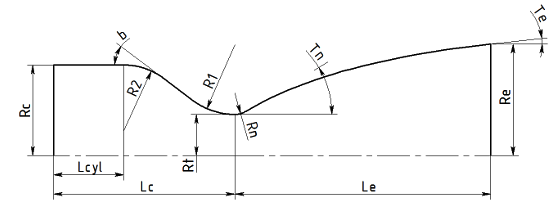

In [ ]:
def lininterp(x, old_min, old_max, new_min, new_max):
  return (x - old_min)/(old_max - old_min) * (new_max - new_min) + new_min

def pointinterp(x, start, end):
  return np.array([start[0] + x * (end[0] - start[0]), start[1] + x * (end[1] - start[1])])

def create_contour(engine, chamber_length, radius_cylinder): #chamber_length = Lc
  rt = np.sqrt(engine.At / np.pi)
  re = np.sqrt(engine.Ae / np.pi)
  Le = 0.8 * rt * (np.sqrt(engine.eps) - 1) / np.tan(15 * np.pi / 180)
  total_length = chamber_length + Le

  Tn = 28 * np.pi / 180
  Te = 10 * np.pi / 180

  # Cyl (For my laziness assume R2 = 0)
  b = 60 * np.pi / 180
  x_conv = chamber_length + 1.5 * rt * np.cos(-b - np.pi / 2)
  y_conv = 2.5 * rt + 1.5 * rt * np.sin(-b - np.pi / 2)

  x_slope = (radius_cylinder - y_conv) / np.tan(b)

  contour_cyl = np.array([
      [0, radius_cylinder],
      [x_conv - x_slope,radius_cylinder],
      [x_conv,y_conv]])

  # Converge -> Throat

  contour_converge_throat = np.zeros((99,2))
  for i in range(1, 100):
    t = lininterp(i, 0, 99, -b - np.pi / 2, - np.pi / 2)
    contour_converge_throat[i - 1] = np.array([chamber_length + 1.5 * rt * np.cos(t), 2.5 * rt + 1.5 * rt * np.sin(t)])

  # Throat -> Parabola

  contour_throat_parabola = np.zeros((99,2))
  for i in range(1, 100):
    t = lininterp(i, 0, 99, 0 - np.pi / 2, Tn - np.pi / 2)
    contour_throat_parabola[i - 1] = np.array([chamber_length + 0.382 * rt * np.cos(t), 1.382 * rt + 0.382 * rt * np.sin(t)])

  # Parabola
  parabola_p0 = contour_throat_parabola[-1]
  parabola_p2 = np.array([total_length, re])
  parabola_m1 = np.tan(Tn)
  parabola_m2 = np.tan(Te)
  parabola_c1 = parabola_p0[1] - parabola_m1 * parabola_p0[0]
  parabola_c2 = parabola_p2[1] - parabola_m2 * parabola_p2[0]
  parabola_p1 = np.array([(parabola_c2 - parabola_c1)/(parabola_m1 - parabola_m2),(parabola_m1 * parabola_c2 - parabola_m2 * parabola_c1)/(parabola_m1 - parabola_m2)])

  contour_parabola = np.zeros((99,2))
  for i in range(1, 100):
    t = lininterp(i, 0, 99, 0, 1)
    parabola_linear0 = pointinterp(t, parabola_p0, parabola_p1)
    parabola_linear1 = pointinterp(t, parabola_p1, parabola_p2)
    contour_parabola[i - 1] = pointinterp(t, parabola_linear0, parabola_linear1)

  contour = np.concatenate([contour_cyl, contour_converge_throat, contour_throat_parabola, contour_parabola])
  final_contour = np.zeros([100, 2])
  final_contour[:,0] = np.linspace(contour[:,0].min(), contour[:,0].max(), num=100)  # Adjust the number of points as needed
  final_contour[:,1] = np.interp(final_contour[:,0], contour[:,0], contour[:,1])

  return final_contour

In [257]:
from scipy.optimize import root_scalar
from pint import UnitRegistry, Quantity
ureg = UnitRegistry()
Q_ = ureg.Quantity


class Thermals:
  def __init__(self, engine, contour, transport_case):
    self.engine = engine
    self.contour = contour

    x_choke = np.argmin(contour[:,1])

    #Finding mach number, https://kyleniemeyer.github.io/gas-dynamics-notes/compressible-flows/isentropic.html#equation-eq-area-ratio-loss
    def area_function(mach, area, gamma):

      area_ratio = area / engine.At
      if mach == 0:
        mach = 0.000001
      return (
          area_ratio - (
              (1.0/mach) * ((1 + 0.5*(gamma-1)*mach*mach) /
              ((gamma + 1)/2))**((gamma+1) / (2*(gamma-1)))
              )
          )

    points = contour.shape[0]
    self.M = np.zeros(points)
    self.T = np.zeros(points)
    self.hg1 = np.zeros(points)
    self.hg2 = np.zeros(points)

    Cv = engine.Cp_c - engine.Rt
    rt = np.sqrt(engine.At / np.pi)

    for i in range(0,contour.shape[0]):


      #Transport case:
      # 0 - throat transports until throat, then linearly interpolate to exit at exit
      # 1 - throat transports
      # 2 - exit transports
      if transport_case == 0:
        if i < x_choke:
          gamma = engine.gt
        else:
          gamma = lininterp(i, x_choke, contour.shape[0], engine.gt, engine.ge)
      elif transport_case == 1:
        gamma = engine.gt
      elif transport_case == 2:
        gamma = engine.ge

      area = np.pi * contour[i,1] * contour[i,1]
      if i == x_choke:
        M = 1
      elif i < x_choke:
        M = root_scalar(area_function, args=(area, gamma), bracket=[0, 1]).root
      else:
        M = root_scalar(area_function, args=(area, gamma), bracket=[1, 10]).root
      self.M[i] = M

      T = engine.Tc - engine.mdot * engine.mdot / (2 * Cv * engine.rho_c * engine.rho_c * area * area) * (1 + 0.5 * (engine.gt - 1) * M * M)**(2 / (engine.gt - 1))
      self.T[i] = T
      correction_factor = 1 / ((0.5 * T / engine.Tc * (1 + 0.5 * (gamma - 1) * M**2)+0.5)**0.68 * (1 + 0.5 * (gamma - 1) * M**2)**0.12)


      r = contour[i,1]
      Cp = engine.Cp_c
      visc = engine.visc
      pr = engine.pr

      #Bartz


      bPc = Q_(engine.Pc, ureg.bar).to('psi')
      bcstar = Q_(engine.cstar, ureg.meter / ureg.second).to('feet / second')
      bDt = Q_(np.sqrt(4 * engine.At / np.pi), ureg.meter).to('inch')
      bcurv = Q_((1.5 * rt + 0.382 * rt) * 0.5, ureg.meter).to("inch")
      bCp = Q_(Cp, ureg.joule / (ureg.kilogram * ureg.degK)).to('Btu / (lb * delta_degF)')
      bvisc = Q_(visc, ureg.lbf * ureg.second/ (ureg.inch ** 2))
      bg = Q_(9.81, ureg.meter / ureg.second**2).to('feet / second**2')
      bAtA = engine.At / area
      self.hg1[i] = Q_((0.026 / bDt**0.2 * (bvisc**0.2 * bCp / pr**0.6) * (bPc * bg / bcstar)**0.8 * (bDt / bcurv)**0.1 * bAtA**0.9 * correction_factor).magnitude, "Btu / (inch ** 2 * second)").to("W / (m**2)").magnitude

      #Adami
      R = engine.Rt
      Z = np.pi * contour[0,1]**2 / (2 * np.pi * contour[0, 1] * contour[-1,0])
      self.hg2[i] = Z * engine.mdot / (2 * area) * Cp * visc**0.3 * pr **(2/3)


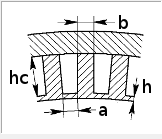

In [270]:
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from matplotlib import pyplot as plt



class Channels:
  def __init__(self, engine, contour, thermals, h): #h = wall thickness

    T_max_wall = 523 #See source
    Tco = 400 #should be nucleate boiling liquid at 10 bars
    stag_recovery = 0.923
    k = 100 #thermal conductiivty of AlSi10Mg

    methanol = Fluid(FluidsList.Methanol).with_state(Input.pressure(10e5), Input.temperature(temp))
    k = methanol.conductivity
    density = methanol.density
    pr = methanol.prandtl

    points = contour.shape[0]
    self.hc = np.zeros(points)
    self.a = np.zeros(points)
    self.A = np.zeros(points)
    self.per = np.zeros(points)

    r_list = contour[:,1]

    hc0 = 0.002
    a0 = 0.005
    r0 = r_list[0]
    self.N = 50
    self.h = h

    for i, r in enumerate(r_list):
      '''
      Taw = thermals.T[i]
      Twg = Taw * stag_recovery
      hg = thermals.hg1[i]

      q = (Twg - T_max_wall) * hg
      Twc = Twg - q * t / k
      hc = q / (Twc - Tco)
      d = 0.0214 * k / hc * ()
      '''
      hc = hc0
      a = a0 * (r + h) / (r0 + h)
      Area = hc0 * a

      a2 = a0 * (r + h + hc) / (r0 + h)

      self.hc[i] = hc0
      self.a[i] = a
      self.A[i] = hc0 * a
      self.per[i] = 2 * hc0 + a + a2



In [268]:
class ChannelSim:
  def __init__(self, engine, contour, thermals, channel):
    mdot = 0.3 / channel.N

    T_max_wall = 523 #See source
    stag_recovery = 0.923
    k_metal = 100 #thermal conductiivty of AlSi10Mg

    points = contour.shape[0]
    self.Taw = np.zeros(points)
    self.Twg = np.zeros(points)
    self.Twc = np.zeros(points)
    self.Tco = np.zeros(points)
    self.velocity = np.zeros(points)
    self.hg = np.zeros(points)
    self.hc = np.zeros(points)
    self.hw = np.zeros(points)
    self.q = np.zeros(points)
    Tco_i = 300

    for i in range(contour.shape[0]-1, -1, -1):
      r = contour[i,1]
      Taw = thermals.T[i]
      Twg = Taw * stag_recovery
      hg = thermals.hg2[i]

      a = channel.a[i]
      A = channel.A[i]
      per = channel.per[i]

      methanol = Fluid(FluidsList.Methanol).with_state(Input.pressure(40e5), Input.temperature(Tco_i))

      k = methanol.conductivity
      density = methanol.density
      pr = methanol.prandtl
      viscosity = methanol.dynamic_viscosity
      cp = methanol.specific_heat

      Dh = 4 * A / per
      velocity = mdot/(A * density)

      Twc = Tco_i + 100
      for j in range(0, 10):
        hc = 0.023 * k / Dh * (density * velocity * Dh / viscosity)**0.8 * pr ** 0.4 * (Twc / Tco_i)**-0.3
        H = 1 / (1 / hg + 0.0001 / 1 + channel.h / k_metal + 1 / hc)
        q = H * (Taw - Tco_i)
        Twc = Tco_i + q / hc

      Twg = Twc + q * channel.h / k_metal


      self.Taw[i] = Taw
      self.Twg[i] = Twg
      self.Twc[i] = Twc
      self.Tco[i] = Tco_i
      self.velocity[i] = velocity
      self.hg[i] = hg
      self.hc[i] = hc
      self.hw[i] = k_metal / channel.h
      self.q[i] = q

      dx = contour[1,0] - contour[0,0]
      Tco_i = Tco_i + 1 / (mdot * cp) * q * a * dx




# Usage

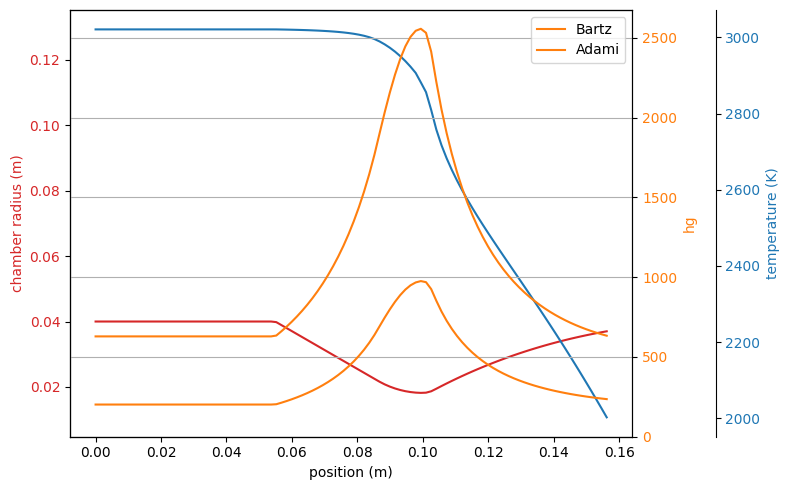

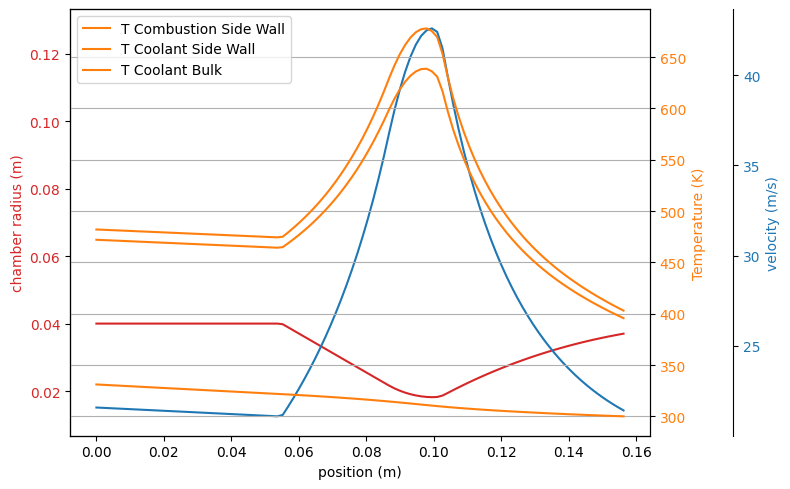

1.3259217483183752

In [271]:
thanos = RocketEngine(
    oxName = "N2O",
    fuelName = "Methanol",
    thrust = 3000,
    Pc = 20,
    Pe = 0.85,
    MR = 3.5)

from matplotlib import pyplot as plt
thanos_contour = create_contour(thanos, 0.1, 0.04)
thanos_thermals = Thermals(thanos, thanos_contour, 0)

fig, ax1 = plt.subplots()
fig.set_size_inches(8, 5)

color = 'tab:red'
ax1.set_xlabel('position (m)')
ax1.set_ylabel('chamber radius (m)', color=color)
ax1.plot(thanos_contour[:,0], thanos_contour[:,1], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_aspect('equal', adjustable='box')
ax1.set_ylim(0, 0.14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('temperature (K)', color=color)  # we already handled the x-label with ax1
ax2.plot(thanos_contour[:,0], thanos_thermals.T, color=color)
ax2.spines['right'].set_position(('outward', 60))
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax3.set_ylabel('hg', color=color)  # we already handled the x-label with ax1
ax3.plot(thanos_contour[:,0], thanos_thermals.hg1, color=color, label='Bartz')
ax3.plot(thanos_contour[:,0], thanos_thermals.hg2, color=color, label='Adami')
ax3.tick_params(axis='y', labelcolor=color)

#ax1.set_aspect('equal', adjustable='box')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax3.set_yticks(np.arange(0, 3000, 500))
plt.grid()
plt.legend(loc='upper right')
plt.show()

thanos_channel = Channels(thanos, thanos_contour, thanos_thermals, 0.002)
channelSim = ChannelSim(thanos, thanos_contour, thanos_thermals, thanos_channel)

fig, ax1 = plt.subplots()
fig.set_size_inches(8, 5)

color = 'tab:red'
ax1.set_xlabel('position (m)')
ax1.set_ylabel('chamber radius (m)', color=color)
ax1.plot(thanos_contour[:,0], thanos_contour[:,1], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_aspect('equal', adjustable='box')
ax1.set_ylim(0, 0.14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('velocity (m/s)', color=color)  # we already handled the x-label with ax1
ax2.plot(thanos_contour[:,0], channelSim.velocity, color=color, label='velocity')
ax2.spines['right'].set_position(('outward', 60))
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax3.set_ylabel('Temperature (K)', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)
#ax3.plot(thanos_contour[:,0], channelSim.Taw, color=color, label='T Combustion Bulk')
ax3.plot(thanos_contour[:,0], channelSim.Twg, color=color, label='T Combustion Side Wall')
ax3.plot(thanos_contour[:,0], channelSim.Twc, color=color, label='T Coolant Side Wall')
ax3.plot(thanos_contour[:,0], channelSim.Tco, color=color, label='T Coolant Bulk')

#ax1.set_aspect('equal', adjustable='box')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#ax3.set_yticks(np.arange(0, 3000, 500))
plt.grid()
plt.legend(loc='upper left')
plt.show()
channelSim.q
thanos.mdot